# Basics of computing sentiment for Reddit headlines

In this notebook, we propose a basic approach to computing sentiment and exploratory text analysis for [Reddit](https://reddit.com) threads in a given subreddit. The analysis compares current week to the prior week for sentiment analysis and then dives into a basic analysis of text for the current week.

 

In [ ]:
import urllib.request
import json 
import datetime

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn

from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pprint import pprint
from IPython import display

We now need to download the lexicon for NLTK, that will be used to analyze the words extracted from Reddit titles. [VADER](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/download/8109/8122) (Valence Aware Dictionary and sEntiment Reasoner) is used as the pre-trained model.

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lmali\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Next, we pre-defined the style for Seaborn, the graphing library we will be using down the line.

In [3]:
seaborn.set(style='darkgrid', context='talk', palette='Dark2')

Now we can define a function that will use the PushShift API to pull in historical Reddit post information. We could use a library like [praw](https://praw.readthedocs.io/en/latest/), however it's capabilities are limited given some [Reddit API changes](https://stackoverflow.com/a/54046328/303696) that restrict timeframe-based lookups.

In [4]:
def load_results(lower_bound_timestamp, upper_bound_timestamp, target_result_size, target_subreddit, score_threshold):
    headline_collection = set()
    
    reddit_data_url = f"https://api.pushshift.io/reddit/submission/search/?after={lower_bound_timestamp}&before={upper_bound_timestamp}&sort_type=score&sort=desc&subreddit={target_subreddit}&limit={target_result_size}&score={score_threshold}"
    
    try:
        with urllib.request.urlopen(reddit_data_url) as url:
            data = json.loads(url.read().decode())
            
            for submission in data['data']:
                headline_collection.add(submission['title'])

        return headline_collection
    except urllib.error.HTTPError as e:
        print(e.__dict__)
        return set()
    except urllib.error.URLError as e:
        print(e.__dict__)
        return set()

Next, we can perform a range of queries against the API to get sets of Reddit posts that match our criteria - coming from the `the selected` subreddit, and with a score of more than 0. We are also running the lookup twice. Once for the past week, and sliding the lookup window by 0.25 days in each call. Using `union()` for set merges ensures that we are not duplicating titles that we are inspecting. The first (roughly) 100 headlines are being pulled for each increment (not the full list of comments - to manage performance). Secondly, we do the same pull for two weeks ago in an effort to review week over week changes.

In [5]:
# Select the subreddit to analyze
selection = input('\n---\nWhich subreddit would like to analyze?\n\n')


---
Which subreddit would like to analyze?

wallstreetbets


In [8]:
headlines = set()

time_now = datetime.datetime.now()

limit_delta = 7
limit_lower_delta = 6.75

subreddit = selection
result_size = 1000
score_limit = ">0"

for i in range(0, 29):
    previous_timestamp = int((time_now - datetime.timedelta(days=limit_delta)).timestamp())
    current_timestamp = int((time_now - datetime.timedelta(days=limit_lower_delta)).timestamp())

    full_collection = load_results(previous_timestamp, current_timestamp, result_size, subreddit, score_limit)
    headlines = headlines.union(full_collection)
    
    limit_delta = limit_delta - 0.25
    limit_lower_delta = limit_lower_delta - 0.25
    
    display.clear_output()
    print(f"Cycle {i}")
    print(len(headlines))

Cycle 28
1740


In [9]:
headlineslastweek = set()

time_now = datetime.datetime.now()

limit_delta = 14
limit_lower_delta = 13.75

subreddit = selection
result_size = 1000
score_limit = ">0"

for i in range(0, 29):
    previous_timestamp = int((time_now - datetime.timedelta(days=limit_delta)).timestamp())
    current_timestamp = int((time_now - datetime.timedelta(days=limit_lower_delta)).timestamp())

    full_collection = load_results(previous_timestamp, current_timestamp, result_size, subreddit, score_limit)
    headlineslastweek = headlineslastweek.union(full_collection)
    
    limit_delta = limit_delta - 0.25
    limit_lower_delta = limit_lower_delta - 0.25
    
    display.clear_output()
    print(f"Cycle {i}")
    print(len(headlineslastweek))

Cycle 28
1998


To get the sentiment, we need to calculate the polarity scores for each line that we have in the set.

In [10]:
sia = SentimentIntensityAnalyzer()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:5], width=100)

[{'compound': -0.6908,
  'headline': 'This is likely how the elite will kill buttcoin',
  'neg': 0.37,
  'neu': 0.63,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'What do you think about multiplan mpln??🚀🚀or💣💣',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.0, 'headline': '$PLTR and other bets', 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': -0.6486,
  'headline': 'Time to go all in on Puts. The Bull Market is officially dead. RIP',
  'neg': 0.249,
  'neu': 0.751,
  'pos': 0.0},
 {'compound': -0.4767,
  'headline': 'The short sellers are trying to attack SPO.CN SponsorsOne Inc. Lets show them whats '
              'up.',
  'neg': 0.181,
  'neu': 0.819,
  'pos': 0.0}]


#Then we do the same for the prior week.

In [11]:
sia = SentimentIntensityAnalyzer()
resultslastweek = []

for line in headlineslastweek:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    resultslastweek.append(pol_score)

pprint(resultslastweek[:5], width=100)

[{'compound': 0.5106,
  'headline': 'Has anyone ever gotten two free stocks from Robinhood after being referred?',
  'neg': 0.0,
  'neu': 0.769,
  'pos': 0.231},
 {'compound': 0.0,
  'headline': 'Can some explain why DOT polkadot is always raising',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.0, 'headline': 'FVRR PDD ¿¿¿¿', 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.5574,
  'headline': 'Cindicator Capital is hiring supreme autists.',
  'neg': 0.0,
  'neu': 0.581,
  'pos': 0.419},
 {'compound': -0.5267,
  'headline': "Shaq, Lebron, &amp; TikTok's Ex-CEO company JUST announced its $3B merger with "
              'Beachbody (Full Retard Mode ACTIVATED)',
  'neg': 0.175,
  'neu': 0.825,
  'pos': 0.0}]


In [12]:
#Converting the results to a data frame makes it much easier to operate.

In [13]:
df = pd.DataFrame.from_records(results)
df.head()

neg    neu  pos  compound  \
0  0.370  0.630  0.0   -0.6908   
1  0.000  1.000  0.0    0.0000   
2  0.000  1.000  0.0    0.0000   
3  0.249  0.751  0.0   -0.6486   
4  0.181  0.819  0.0   -0.4767   

                                            headline  
0    This is likely how the elite will kill buttcoin  
1     What do you think about multiplan mpln??🚀🚀or💣💣  
2                               $PLTR and other bets  
3  Time to go all in on Puts. The Bull Market is ...  
4  The short sellers are trying to attack SPO.CN ...

In [14]:
df2 = pd.DataFrame.from_records(resultslastweek)
df2.head()

neg    neu    pos  compound  \
0  0.000  0.769  0.231    0.5106   
1  0.000  1.000  0.000    0.0000   
2  0.000  1.000  0.000    0.0000   
3  0.000  0.581  0.419    0.5574   
4  0.175  0.825  0.000   -0.5267   

                                            headline  
0  Has anyone ever gotten two free stocks from Ro...  
1  Can some explain why DOT polkadot is always ra...  
2                                      FVRR PDD ¿¿¿¿  
3      Cindicator Capital is hiring supreme autists.  
4  Shaq, Lebron, &amp; TikTok's Ex-CEO company JU...

Based on the compound assessed value, we can determine whether the headline that we are analyzing is positive or negative. We can label that accordingly with a `1` value for positive sentiment and `-1` value for negative sentiment.

In [15]:
df['label'] = 0
df.loc[df['compound'] > 0, 'label'] = 1
df.loc[df['compound'] < 0, 'label'] = -1
df.head()

neg    neu  pos  compound  \
0  0.370  0.630  0.0   -0.6908   
1  0.000  1.000  0.0    0.0000   
2  0.000  1.000  0.0    0.0000   
3  0.249  0.751  0.0   -0.6486   
4  0.181  0.819  0.0   -0.4767   

                                            headline  label  
0    This is likely how the elite will kill buttcoin     -1  
1     What do you think about multiplan mpln??🚀🚀or💣💣      0  
2                               $PLTR and other bets      0  
3  Time to go all in on Puts. The Bull Market is ...     -1  
4  The short sellers are trying to attack SPO.CN ...     -1

In [16]:
df2['label'] = 0
df2.loc[df2['compound'] > 0, 'label'] = 1
df2.loc[df2['compound'] < 0, 'label'] = -1
df2.head()

neg    neu    pos  compound  \
0  0.000  0.769  0.231    0.5106   
1  0.000  1.000  0.000    0.0000   
2  0.000  1.000  0.000    0.0000   
3  0.000  0.581  0.419    0.5574   
4  0.175  0.825  0.000   -0.5267   

                                            headline  label  
0  Has anyone ever gotten two free stocks from Ro...      1  
1  Can some explain why DOT polkadot is always ra...      0  
2                                      FVRR PDD ¿¿¿¿      0  
3      Cindicator Capital is hiring supreme autists.      1  
4  Shaq, Lebron, &amp; TikTok's Ex-CEO company JU...     -1

Now, we can isolate the headlines and labels into a separate data frame, and store the data in a CSV file that we can work with later on.

In [17]:
working_dataframe1 = df[['headline', 'label']]
working_dataframe1.to_csv('thisweekheadlines.csv', mode='a', encoding='utf-8', index=False)

In [18]:
working_dataframe2 = df2[['headline', 'label']]
working_dataframe2.to_csv('lastweekheadlines.csv', mode='a', encoding='utf-8', index=False)

Let's take a look at what headlines we have.

In [19]:
print("Positive headlines this week:\n")
pprint(list(df[df['label'] == 1].headline)[:20], width=200)

print("\nNegative headlines this week:\n")
pprint(list(df[df['label'] == -1].headline)[:20], width=200)

Positive headlines this week:

["The long-awaited movie adaptation is finally done! Here's the trailer.. hope you'll like it (Link to full-length film in comments)",
 "When I'm r/wallstreetbets retard (enjoy you gorgeous apes)",
 "Ape gang clearly didn't drink enough water: fiber supplements shelf almost cleared",
 'Will FREE coin be the next One to the MOON. Current price at 0.00000181 USD',
 'Intrinsic Value Calculations',
 'GameStop should create a cryptocurrency based on their incentive program - GameCoin',
 'Discerning reply’s only.. YOLO call options or bust.',
 'Get #saveroaringkitty trending on twitter, and save DeepFuckingValue!',
 'EMAN for the win. 4.30 dip to 5.15. Purchasing power for us smaller financed degenerates.',
 'Should I buy ASX: PLS',
 'HERO!!!',
 'Star Diamond Corp. DIAM.TO',
 'Ordered some shoes... they even want me to return these to Citadel. They want everything back!',
 '$LHDX - At Home COVID-19 Test- FDA approved! 30 min Results! 📈🚀🆙',
 'REMINDER: RETAIL IN

In [20]:
print("Positive headlines last week:\n")
pprint(list(df2[df2['label'] == 1].headline)[:20], width=200)

print("\nNegative headlines last week:\n")
pprint(list(df2[df2['label'] == -1].headline)[:20], width=200)

Positive headlines last week:

['Has anyone ever gotten two free stocks from Robinhood after being referred?',
 'Cindicator Capital is hiring supreme autists.',
 'Yay, finally boarded Reddit 🤣 Your take on HYLN?',
 'Impressing myself one day at a time',
 'Gme to the moon yes but anyone thinking beach body when it drops',
 "If I invested 100 dollars into today's market, betting it all or nothing, what would I need to know to turn that into a hefty profit?",
 'What is the best investing app?',
 'Give me your shares my apes!!',
 "I'm so glad my business is private sector. Could u imagine dealing with all these emails from people with $5 of stock in half billion dollar company telling u how to run your business. Let these "
 "people do there jobs. If u don't agree or don't condone then don't invest. Your money is your voice.",
 "Well, this is what my wife's boyfriend told me",
 "Happy Valentine's Day",
 'happy',
 'White House launches clean energy effort, $100 million in technology funding

In [51]:
thisweek = pd.read_csv('thisweekheadlines.csv')
positive_thisweek = thisweek[thisweek['label'] == 1]
positive_thisweek.head()

headline  label
5   The long-awaited movie adaptation is finally d...      1
7   When I'm r/wallstreetbets retard (enjoy you go...      1
9   Ape gang clearly didn't drink enough water: fi...      1
12  Will FREE coin be the next One to the MOON. Cu...      1
21                       Intrinsic Value Calculations      1

In [52]:
negative_thisweek = thisweek[thisweek['label'] == -1]
negative_thisweek.head()

headline  label
0     This is likely how the elite will kill buttcoin     -1
3   Time to go all in on Puts. The Bull Market is ...     -1
4   The short sellers are trying to attack SPO.CN ...     -1
8   Think reddit ads are trying to tell me to stop...     -1
18  Interactive Brokers founder and chairman on ga...     -1

In [53]:
lastweek = pd.read_csv('lastweekheadlines.csv')
positive_lastweek = lastweek[lastweek['label'] == 1]
positive_lastweek.head()

headline  label
0   Has anyone ever gotten two free stocks from Ro...      1
3       Cindicator Capital is hiring supreme autists.      1
7    Yay, finally boarded Reddit 🤣 Your take on HYLN?      1
12                Impressing myself one day at a time      1
13  Gme to the moon yes but anyone thinking beach ...      1

In [54]:
negative_lastweek = lastweek[lastweek['label'] == -1]
negative_lastweek.head()

headline  label
4   Shaq, Lebron, &amp; TikTok's Ex-CEO company JU...     -1
5   Unpopular opinion: I really hope wsb doesn't g...     -1
19  Hi Melvin, Hi Capital. This is a negative post...     -1
33                          Help, life is killing me.     -1
48  A noob who is here for advice. Not financial a...     -1

In [55]:
thisweek['week']="thisweek"


In [56]:
lastweek['week']="lastweek"

In [57]:
bothweeks = pd.concat([thisweek, lastweek], axis=0)

In [58]:
bothweeks.to_csv('bothweeks.csv', mode='a', encoding='utf-8', index=False)

In [59]:
# View 10 most common words prior to text pre-processing
freq = pd.Series(' '.join(map(str, positive_thisweek['headline'])).split()).value_counts()[:10]
freq

the    202
to     163
a      115
and    114
I      110
of      96
for     69
in      69
on      66
is      63
dtype: int64

In [60]:
# View 10 least common words prior to text pre-processing
freq1 =  pd.Series(' '.join(map(str,positive_thisweek['headline'])).split()).value_counts()[-10:]
freq1

Bluff       1
$AAPL       1
factory     1
Kong.       1
😔           1
four        1
out,        1
Account,    1
amazon      1
makers      1
dtype: int64

In [61]:
# Now we create a list of stopwords

In [62]:
# Import libraries for text preprocessing
import re

# You only need to download these resources once. After you run this 
# the first time--or if you know you already have these installed--
# you can comment these two lines out (with a #)

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lmali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lmali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))
print(sorted(stop_words))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [64]:
# Load a set of custom stop words from a text file (one stopword per line)
csw = set(line.strip() for line in open('custom-stopwords.txt'))
csw = [sw.lower() for sw in csw]
print(sorted(csw))

['hello', 'thank', 'wondering', 'would']


In [65]:
# Combine custom stop words with stop_words list
stop_words = stop_words.union(csw)
print(sorted(stop_words))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'hello', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so'

In [66]:
## 3. Pre-process the dataset to get a cleaned, normalized text corpus  

In [67]:
# Pre-process dataset to get a cleaned and normalised text corpus
corpus = []
thisweek['word_count'] = thisweek['headline'].apply(lambda x: len(str(x).split(" ")))
ds_count = len(thisweek.word_count)
for i in range(0, ds_count):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(thisweek['headline'][i]))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Convert to list from string
    text = text.split()
    
    # Stemming
    ps=PorterStemmer()
    
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [68]:
corpus[22]

'platform switch fck robinhood'

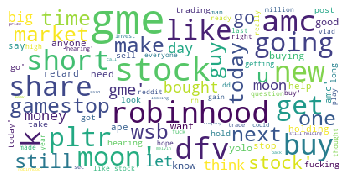

In [69]:
# Generate word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("wordcloud.png", dpi=900)

In [70]:
# Tokenize the text and build a vocabulary of known words
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [71]:
# Sample the returned vector encoding the length of the entire vocabulary
list(cv.vocabulary_.keys())[:17]

['elite',
 'kill',
 'buttcoin',
 'elite kill',
 'elite kill buttcoin',
 'think',
 'multiplan',
 'mpln',
 'think multiplan',
 'multiplan mpln',
 'think multiplan mpln',
 'pltr',
 'bet',
 'pltr bet',
 'time',
 'go',
 'put']

In [72]:
#4. Extract most frequently occurring keywords and n-grams

      Keyword  Frequency
0         gme        155
1       stock        131
2        like         79
3         amc         75
4   robinhood         73
5         buy         69
6        moon         64
7         dfv         62
8       share         56
9       still         55
10      short         53
11       pltr         52
12      today         50
13        get         49
14   gamestop         48
15         go         46
16       time         45
17    holding         44
18      going         42
19        wsb         41


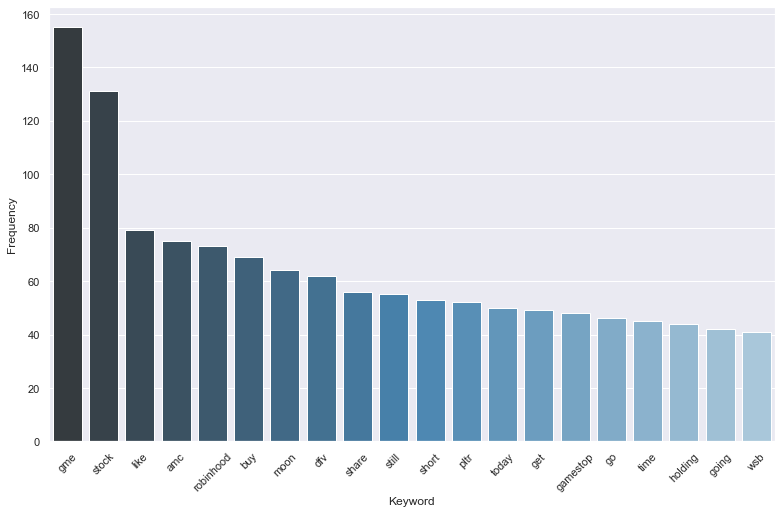

In [73]:
# View most frequently occuring keywords
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot, save as CSV
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Keyword", "Frequency"]
print(top_df)
top_df.to_csv('_top_words.csv')

# Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Keyword", y="Frequency", data=top_df, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.figure.savefig("_keyword.png", bbox_inches = "tight")

                  Bi-gram  Frequency
0              like stock         28
1           still holding         22
2            diamond hand         15
3               loss porn         12
4           roaring kitty         10
5             anyone else          9
6             holding gme          8
7              keith gill          8
8              robin hood          7
9           short squeeze          7
10                gme amc          7
11          robinhood ceo          7
12                let get          7
13  congressional hearing          7
14                buy dip          6
15             hedge fund          6
16              long term          6
17              beat beat          6
18              amc still          5
19                 let go          5


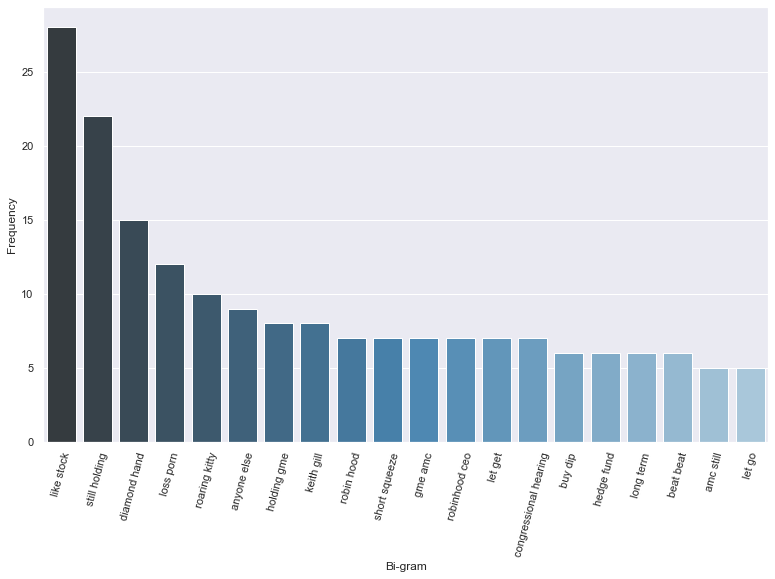

In [74]:
# Most frequently occuring bigrams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# Convert most freq bigrams to dataframe for plotting bar plot, save as CSV
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Frequency"]
print(top2_df)
top2_df.to_csv('_bigrams.csv')

# Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Frequency", data=top2_df, palette="Blues_d")
h.set_xticklabels(h.get_xticklabels(), rotation=75)
h.figure.savefig("_bi-gram.png", bbox_inches = "tight")

                  Tri-gram  Frequency
0        still holding gme          5
1           beat beat beat          4
2        amc still holding          3
3          gme yolo update          3
4      sued security fraud          3
5         much honest work          3
6       roaring kitty sued          3
7     bought million share          3
8           next big thing          3
9          said like stock          3
10  churchill capital corp          3
11          hope like link          2
12          like link full          2
13       still holding amc          2
14         yolo update feb          2
15        mine cyber money          2
16        cyber money free          2
17  hitif make millionaire          2
18     ape together strong          2
19         wsb please stop          2


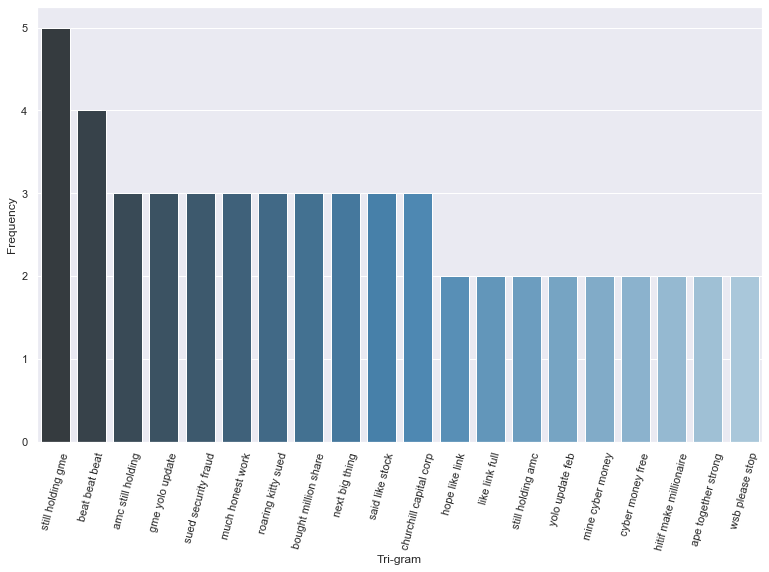

In [75]:
# Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# Convert most freq trigrams to dataframe for plotting bar plot, save as CSV
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Frequency"]
print(top3_df)
top3_df.to_csv('_trigrams.csv')

# Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Frequency", data=top3_df, palette="Blues_d")
j.set_xticklabels(j.get_xticklabels(), rotation=75)
j.figure.savefig("_tri-gram.png", bbox_inches = "tight")

In [77]:
#Now we will populate word clouds for positive and negative headlines separately for this week.

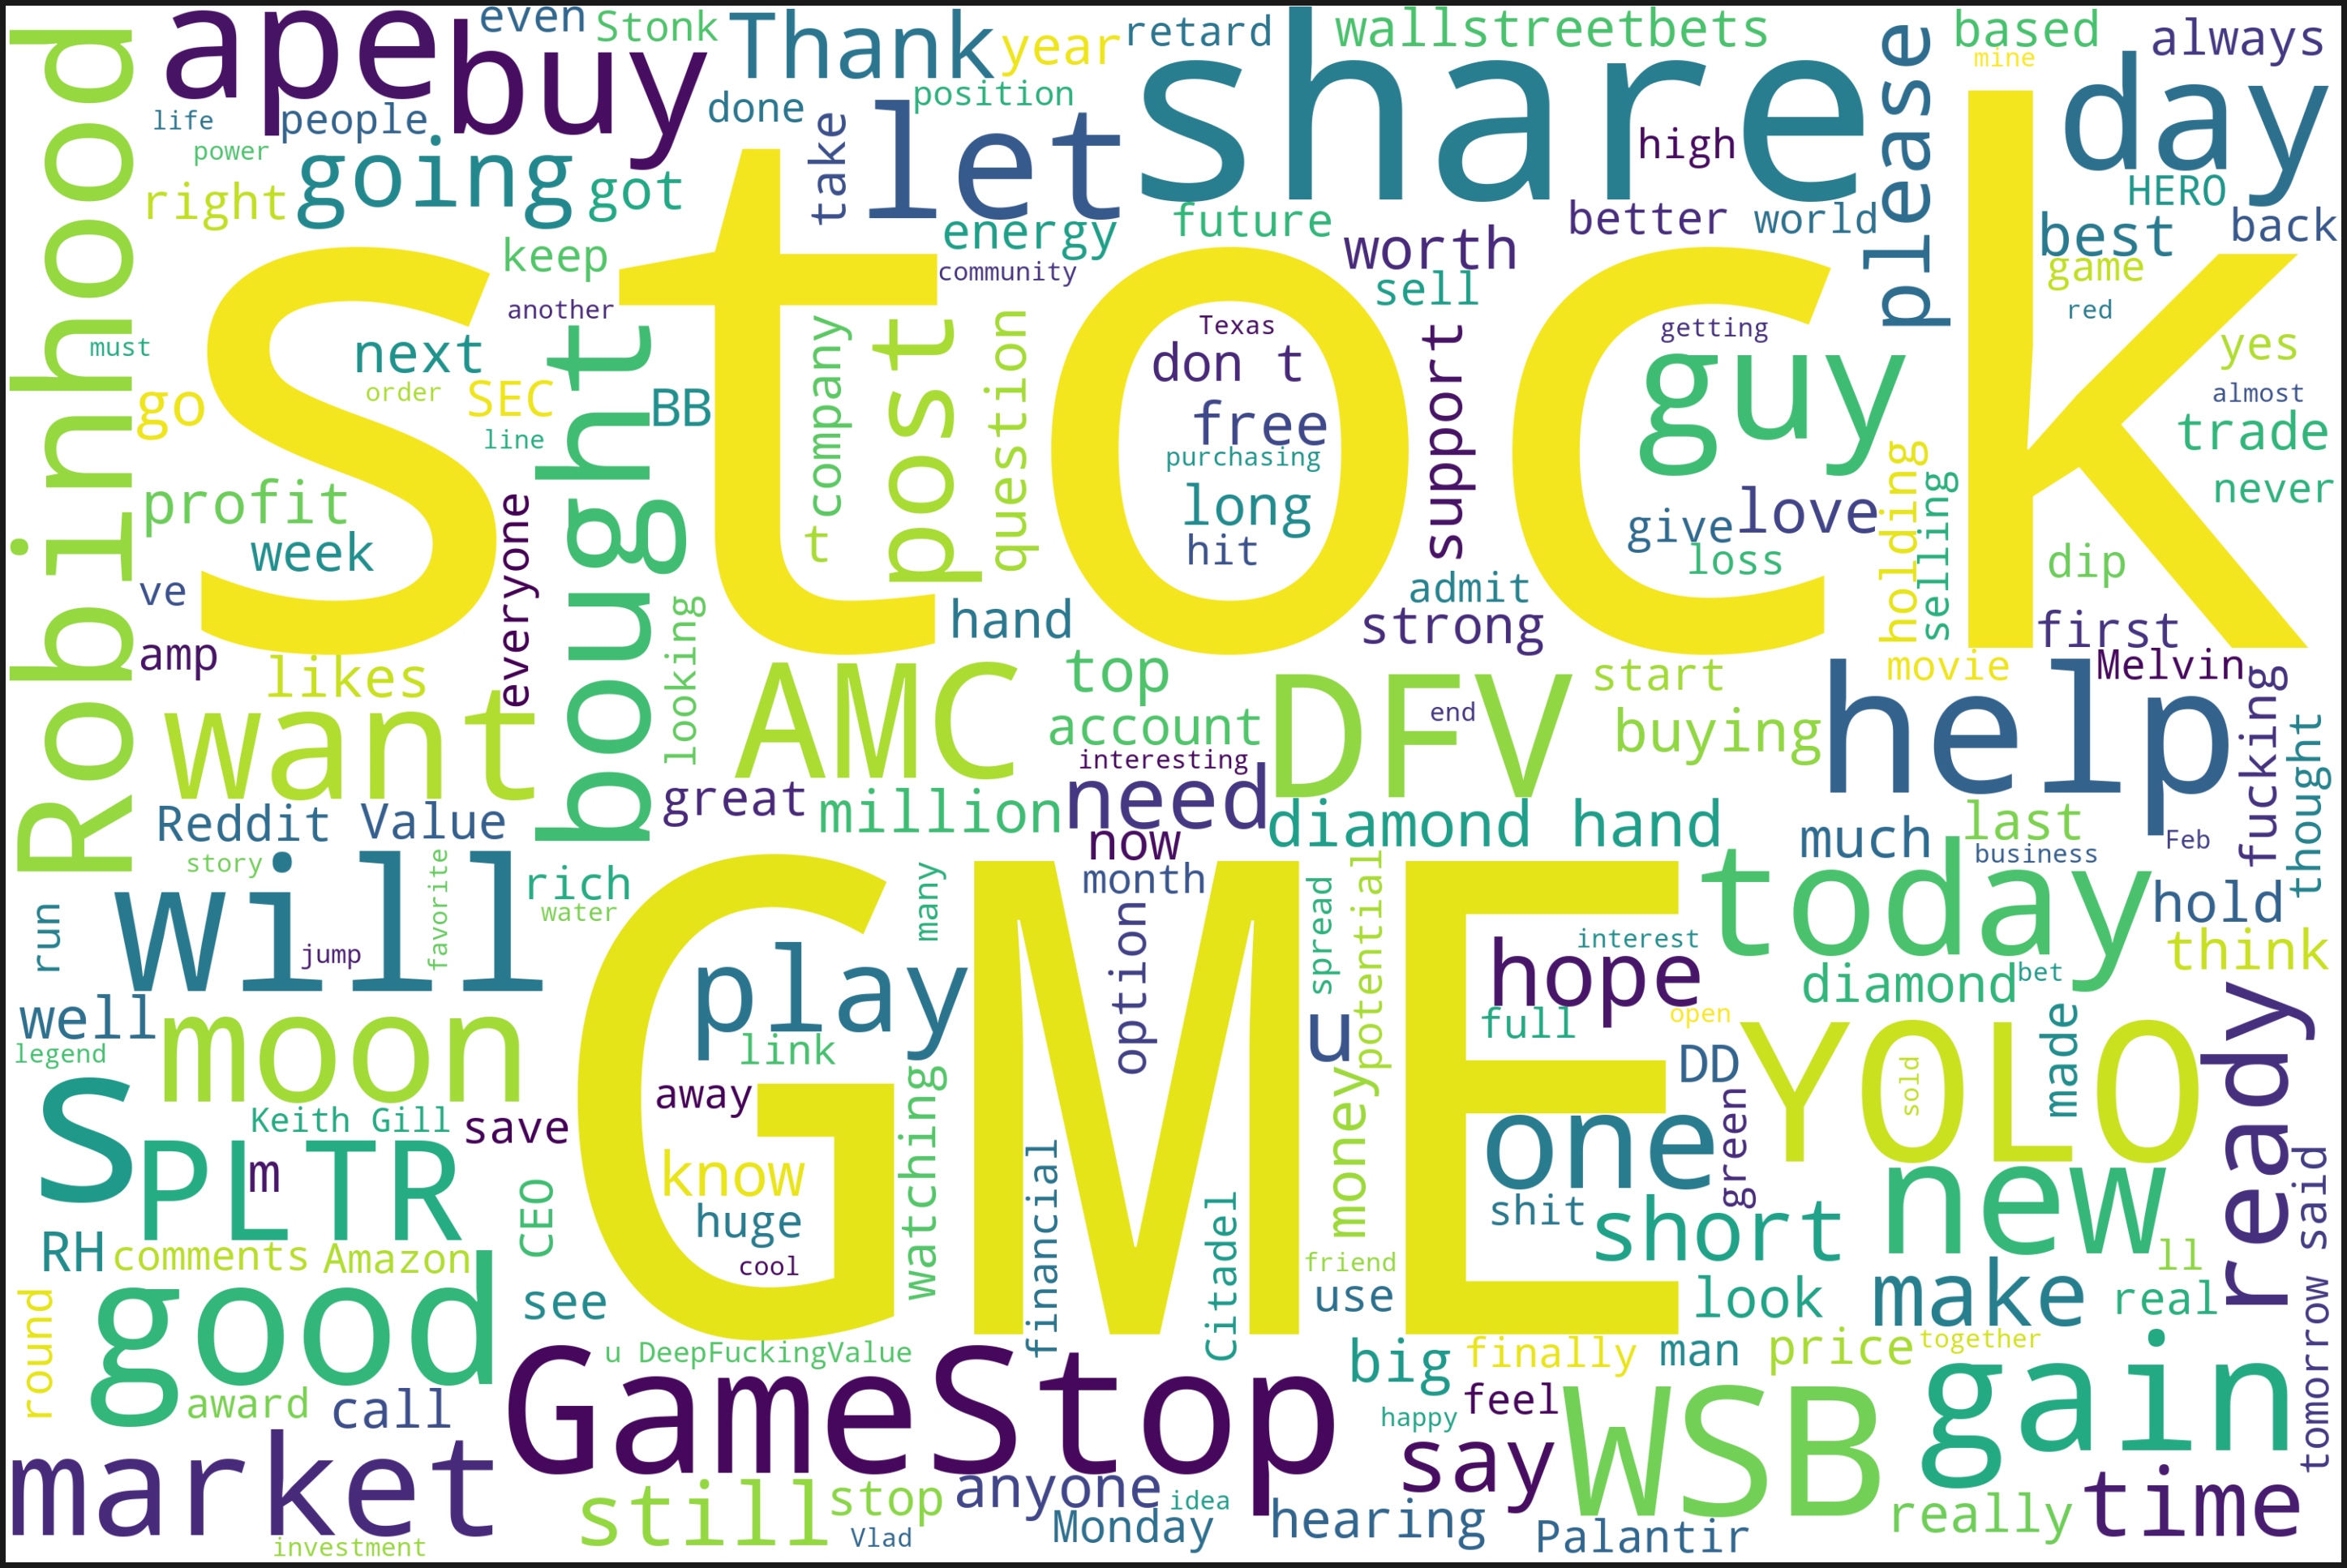

In [76]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(positive_thisweek['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

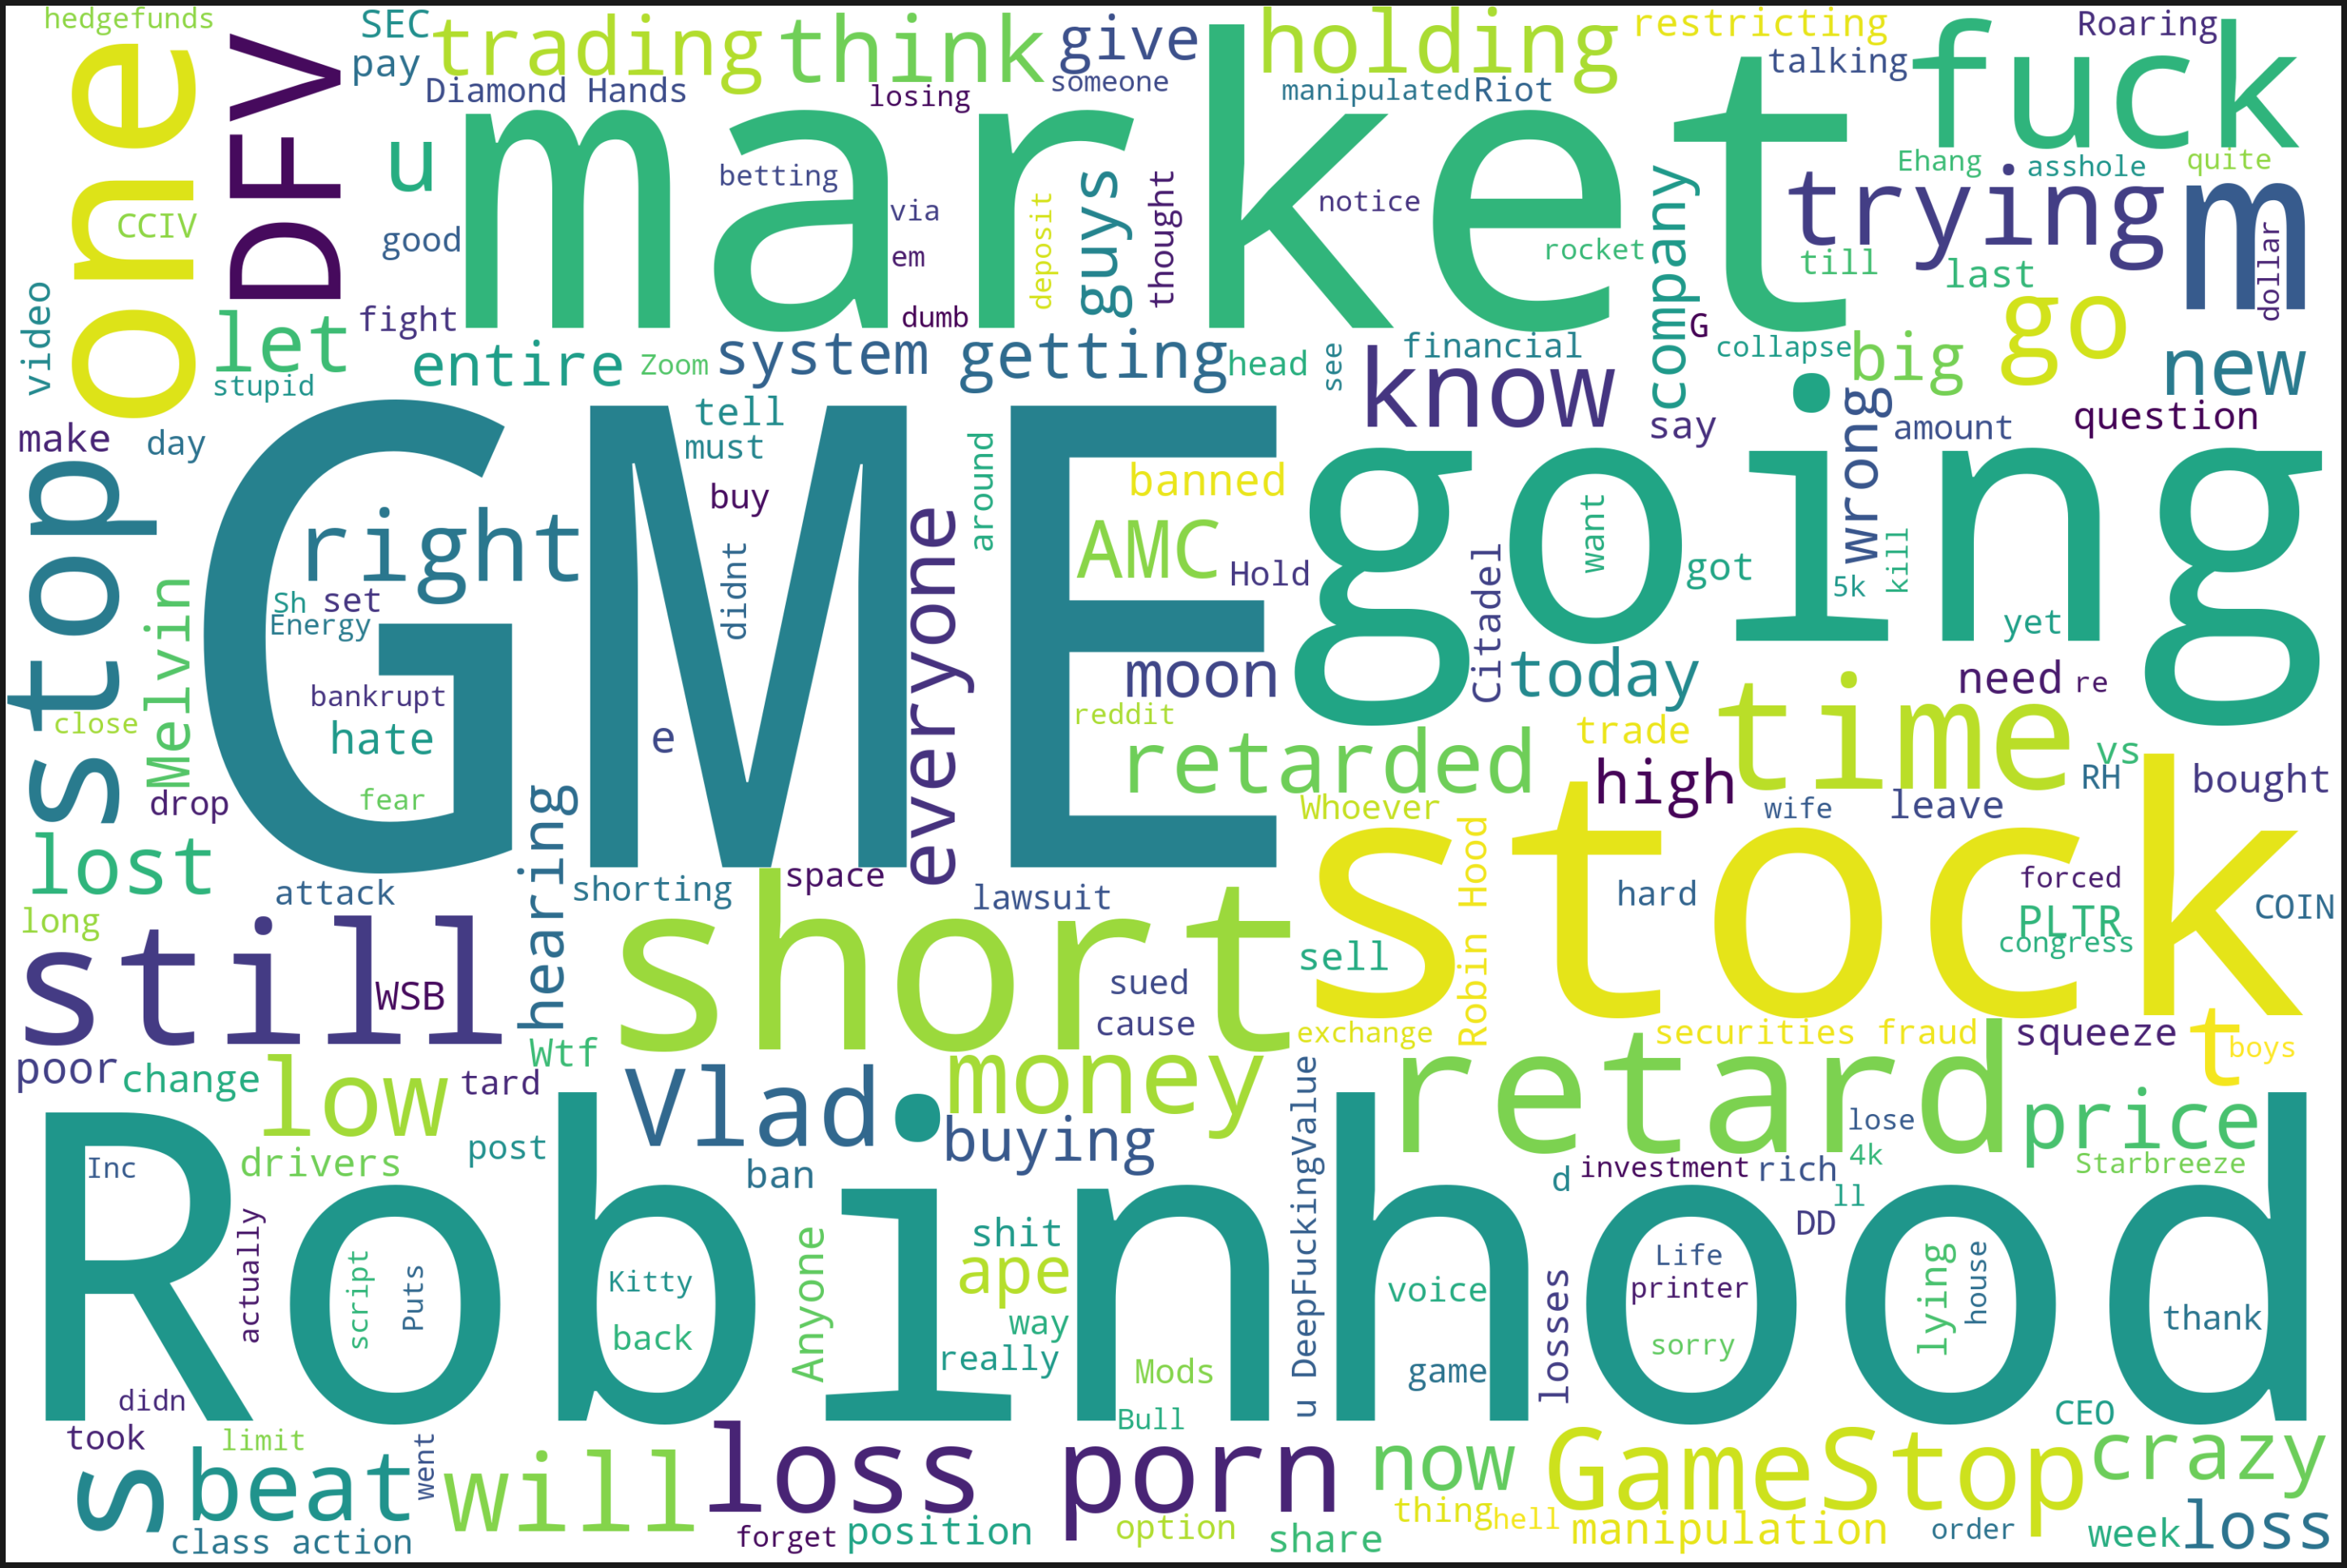

In [78]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(negative_thisweek['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Now the word clouds for the prior week

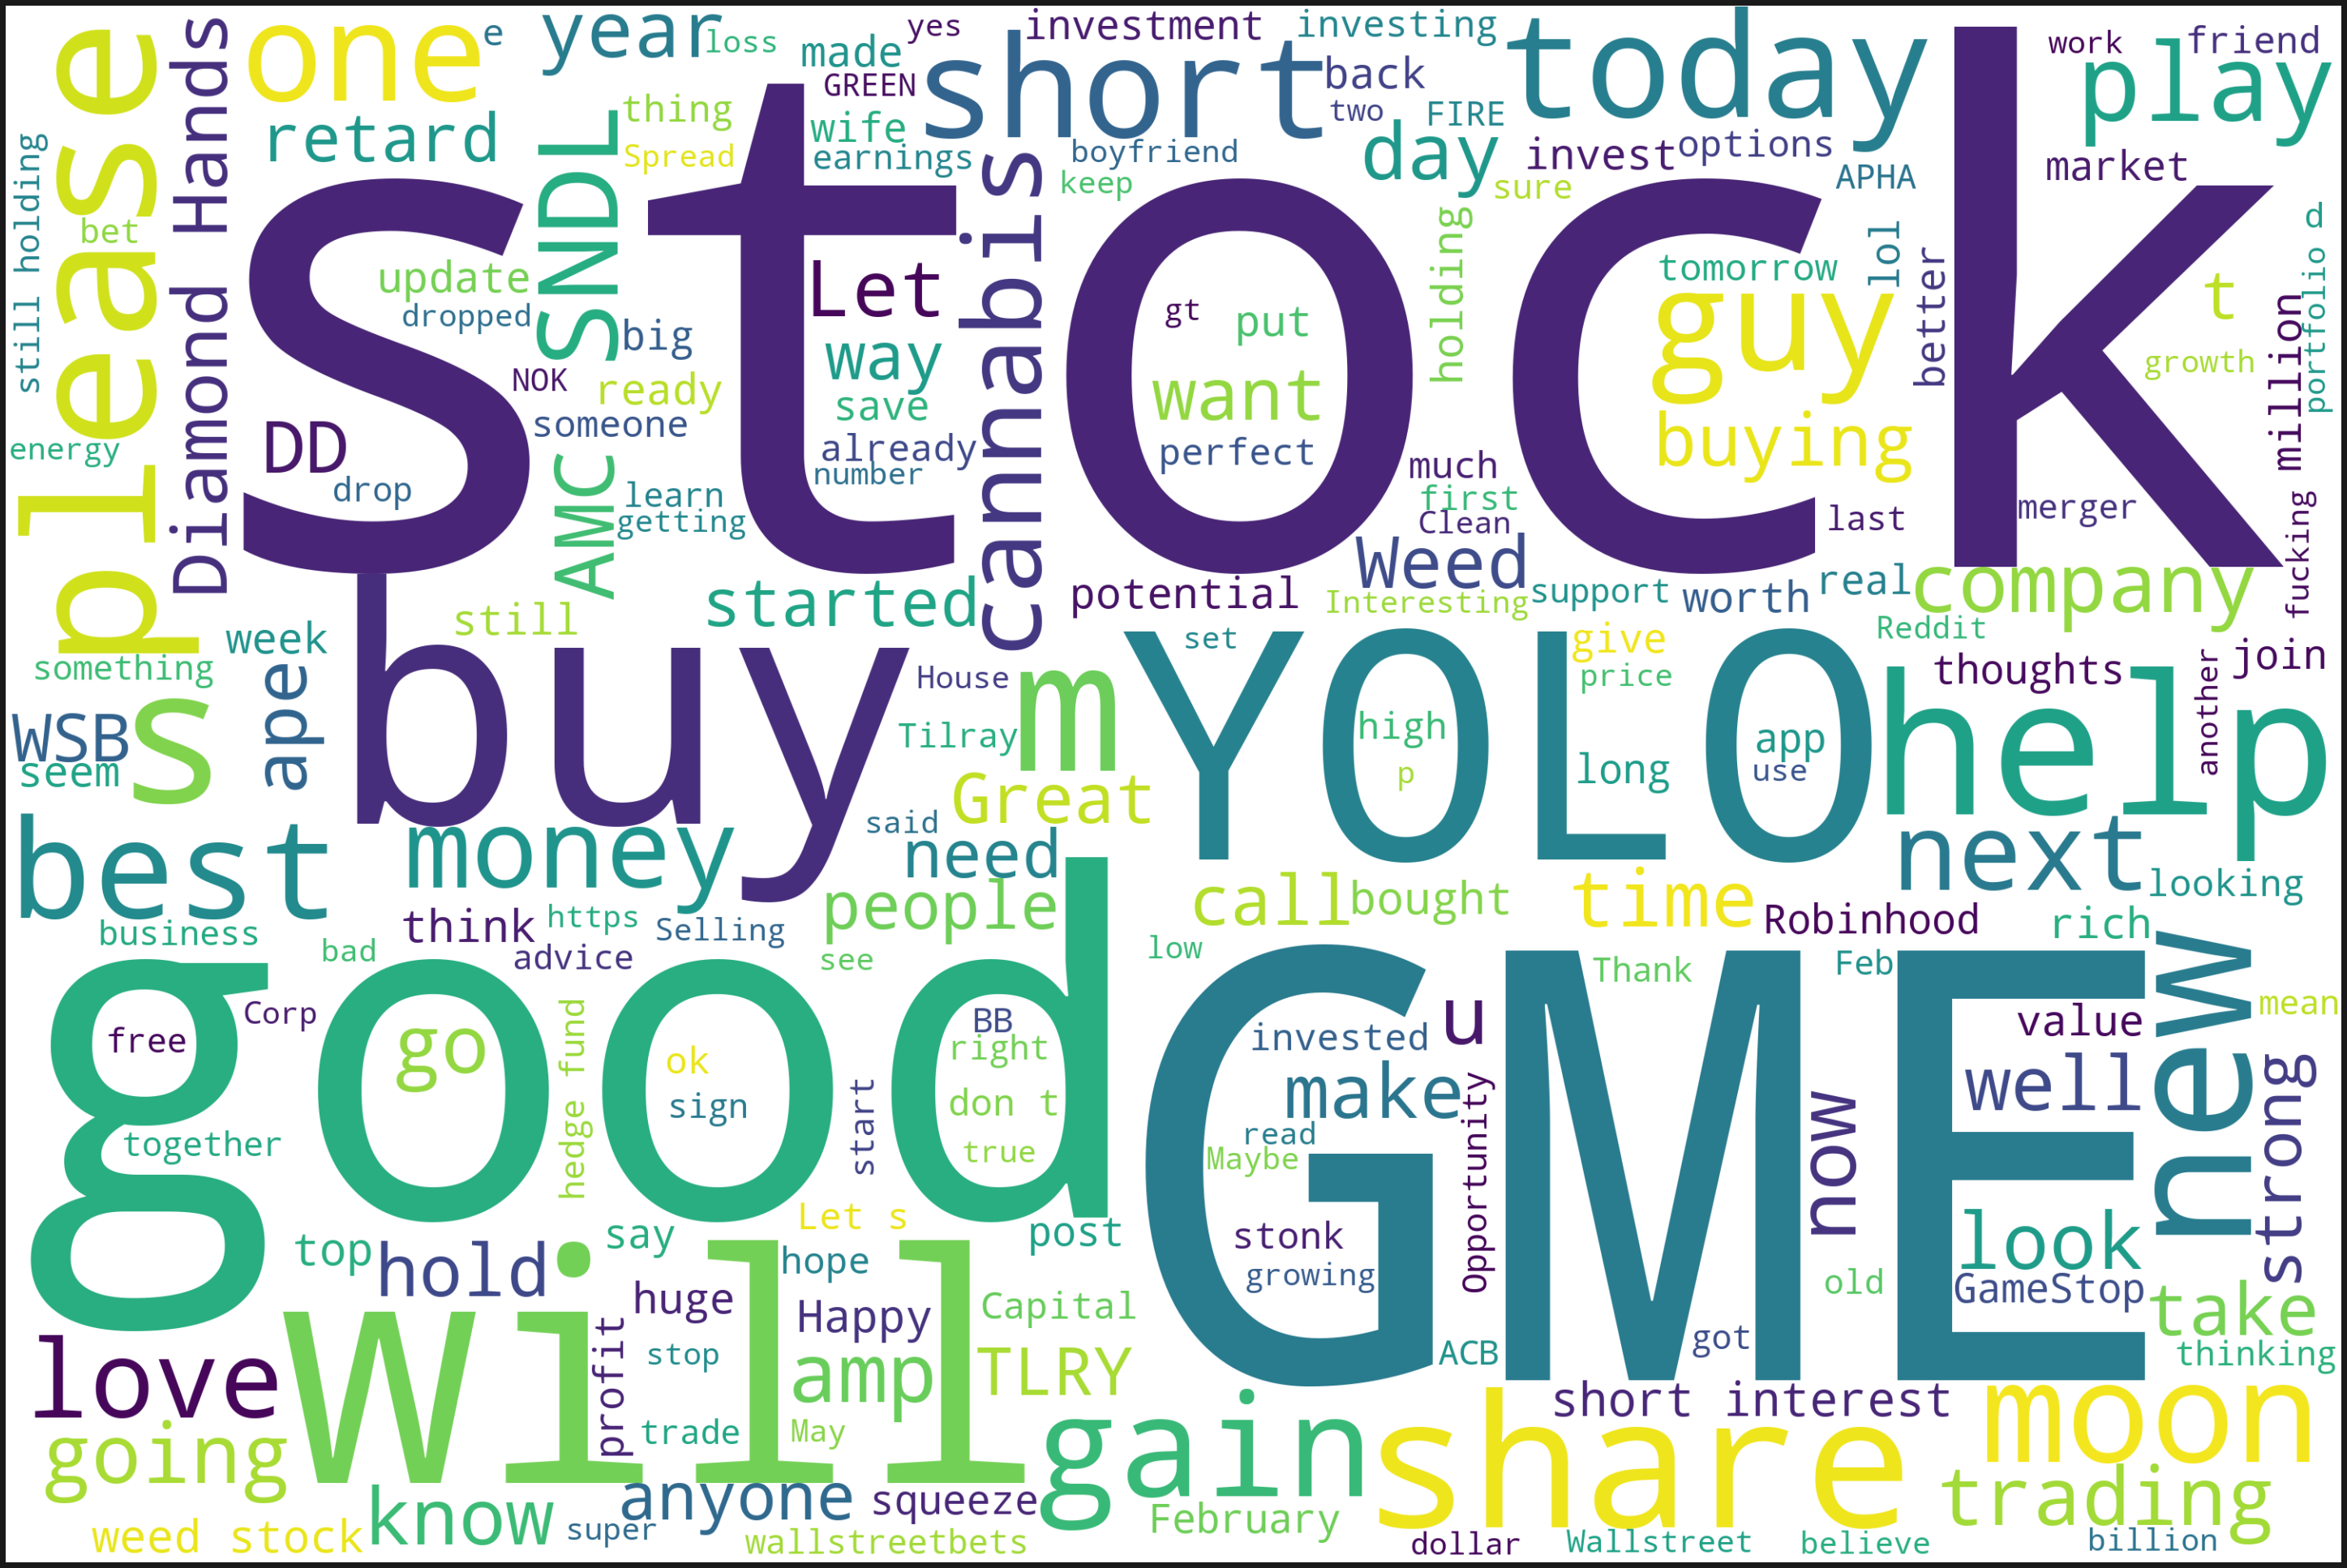

In [79]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(positive_lastweek['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

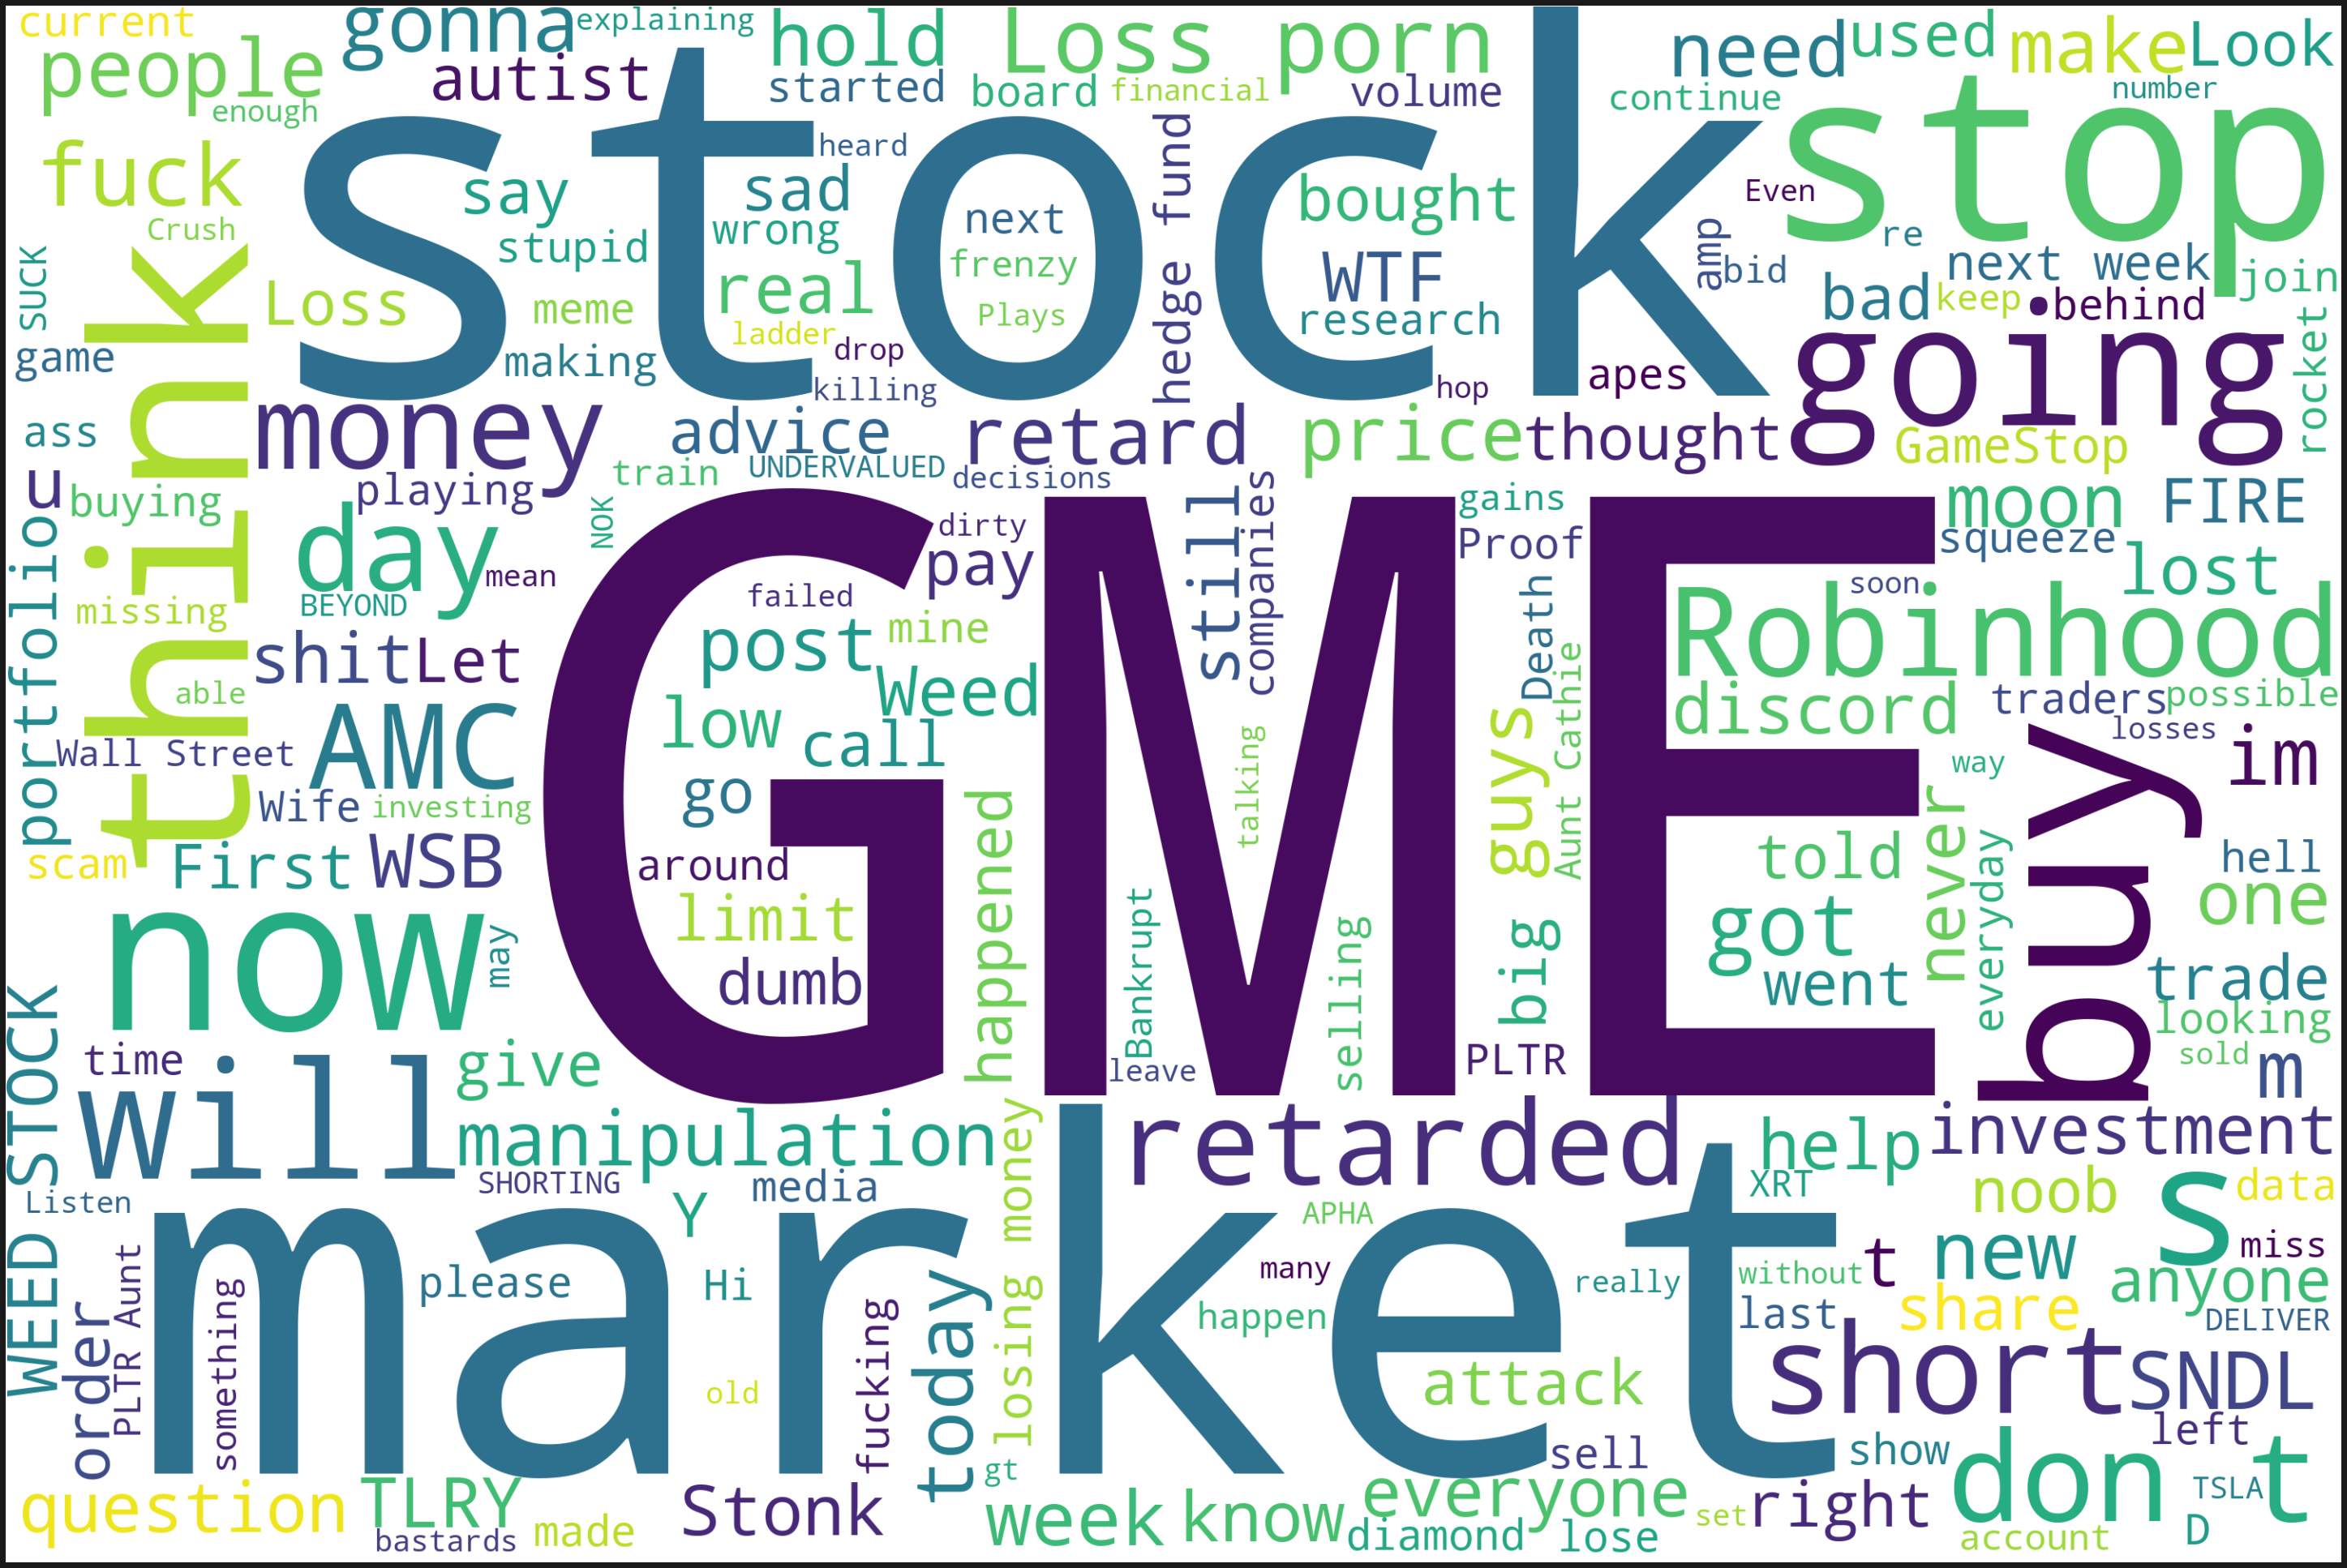

In [80]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(negative_lastweek['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Last but not least, we will calculate the counts of negative, neutral and positive titles in the weeks that we obtained.

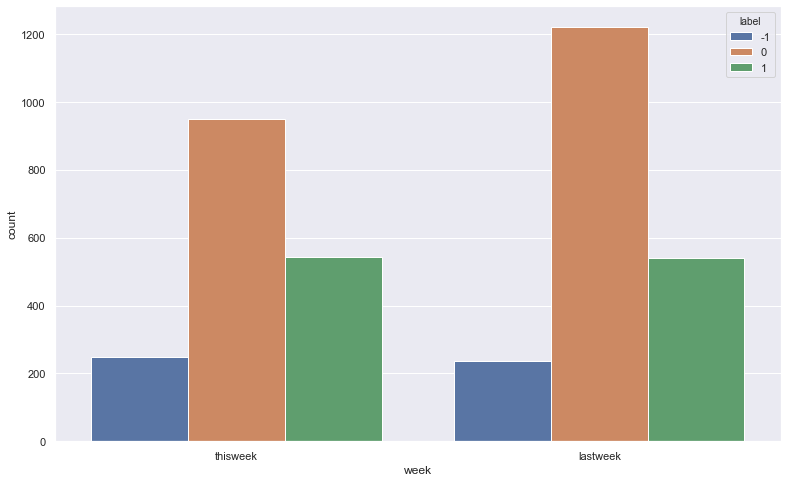

In [81]:
# count plot on two categorical variable
seaborn.countplot(x ='week', hue = "label", data = bothweeks)
 
# Show the plot
plt.show()

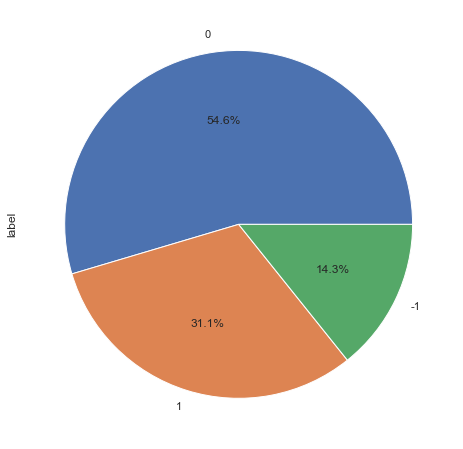

In [82]:
pieplot = thisweek.label.value_counts(normalize=True) * 100
pieplot.plot.pie(autopct="%.1f%%");

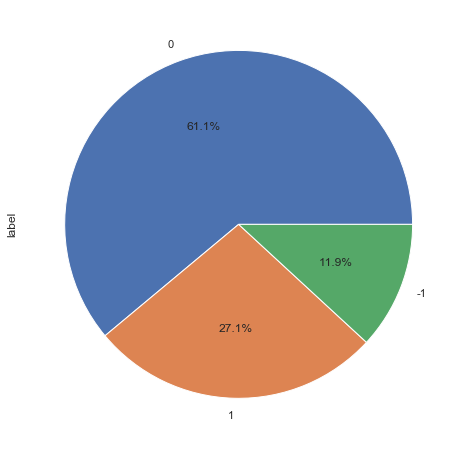

In [83]:
pieplot = lastweek.label.value_counts(normalize=True) * 100
pieplot.plot.pie(autopct="%.1f%%");

In [84]:
#5. Extract a list of top TF-IDF terms¶

In [85]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(corpus)
word_count_vector.shape

(1740, 3143)

In [86]:
# Get TF-IDF (term frequency/inverse document frequency) -- 
# TF-IDF lists word frequency scores that highlight words that 
# are more important to the context rather than those that 
# appear frequently across documents

from sklearn.feature_extraction.text import TfidfTransformer 

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

idf_weights
gme           3.438334
stock         3.633901
like          4.144727
robinhood     4.185549
amc           4.199535
...                ...
gurufocus     7.769068
gxgx          7.769068
haha          7.769068
grow          7.769068
knee          7.769068

[3143 rows x 1 columns]

In [87]:
# count matrix 
count_vector=cv.transform(corpus) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [88]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

tfidf
elite      0.513213
likely     0.513213
buttcoin   0.486428
kill       0.486428
place      0.000000
...             ...
finally    0.000000
finance    0.000000
financed   0.000000
financial  0.000000
zoom       0.000000

[3143 rows x 1 columns]

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here 
tfidf_vectorizer=TfidfVectorizer(use_idf=True) 
 
# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(corpus)

In [90]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 

In [91]:
first_vector_tfidfvectorizer

<1x3143 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>